In [126]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Conv1D,MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os
import librosa
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import IPython.display as ipd

In [6]:
files_metadata = pd.read_csv('UrbanSound8K.csv')
files_metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
print(files_metadata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB
None


['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


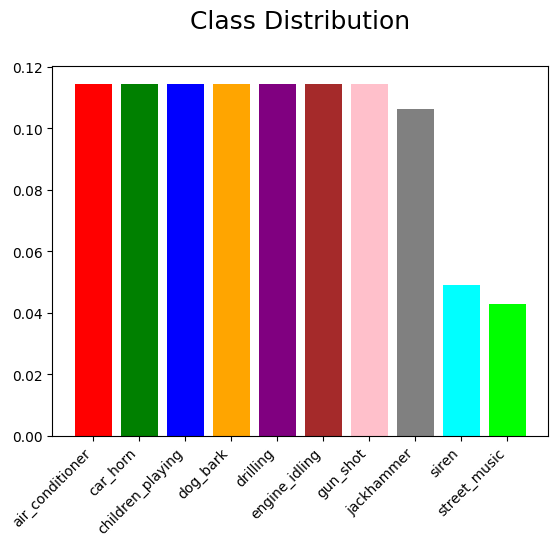

In [35]:
class_dict = files_metadata['class'].value_counts(normalize=True)
classes = np.unique(files_metadata['class'])
print(classes)
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'lime']
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08, fontsize=18)
ax.bar(classes,class_dict.values, color=colors)
plt.xticks(rotation=45, ha='right')
plt.show(block=False)

In [37]:
DURATION = 4
SAMPLE_RATE = 44100
HOP_LENGTH = round(SAMPLE_RATE * 0.0125)
WIN_LENGTH = round(SAMPLE_RATE * 0.023)
N_FFT = 2**10
TIME_SIZE = 4*SAMPLE_RATE//HOP_LENGTH+1
AUDIO_PATH = "../urbansound8K/audio/"

In [106]:
def reformat_audio_data(audio_file_path):
    audio_data_res, _ = librosa.load(audio_file_path,sr=SAMPLE_RATE)

    audio_duration = librosa.get_duration(y=audio_data_res,sr=SAMPLE_RATE)
    if audio_duration < DURATION:
        audio_data_adj = np.pad(audio_data_res, (0, int((DURATION-audio_duration)*SAMPLE_RATE)), 'constant')
    else:
        audio_data_adj = audio_data_res
    return audio_data_adj

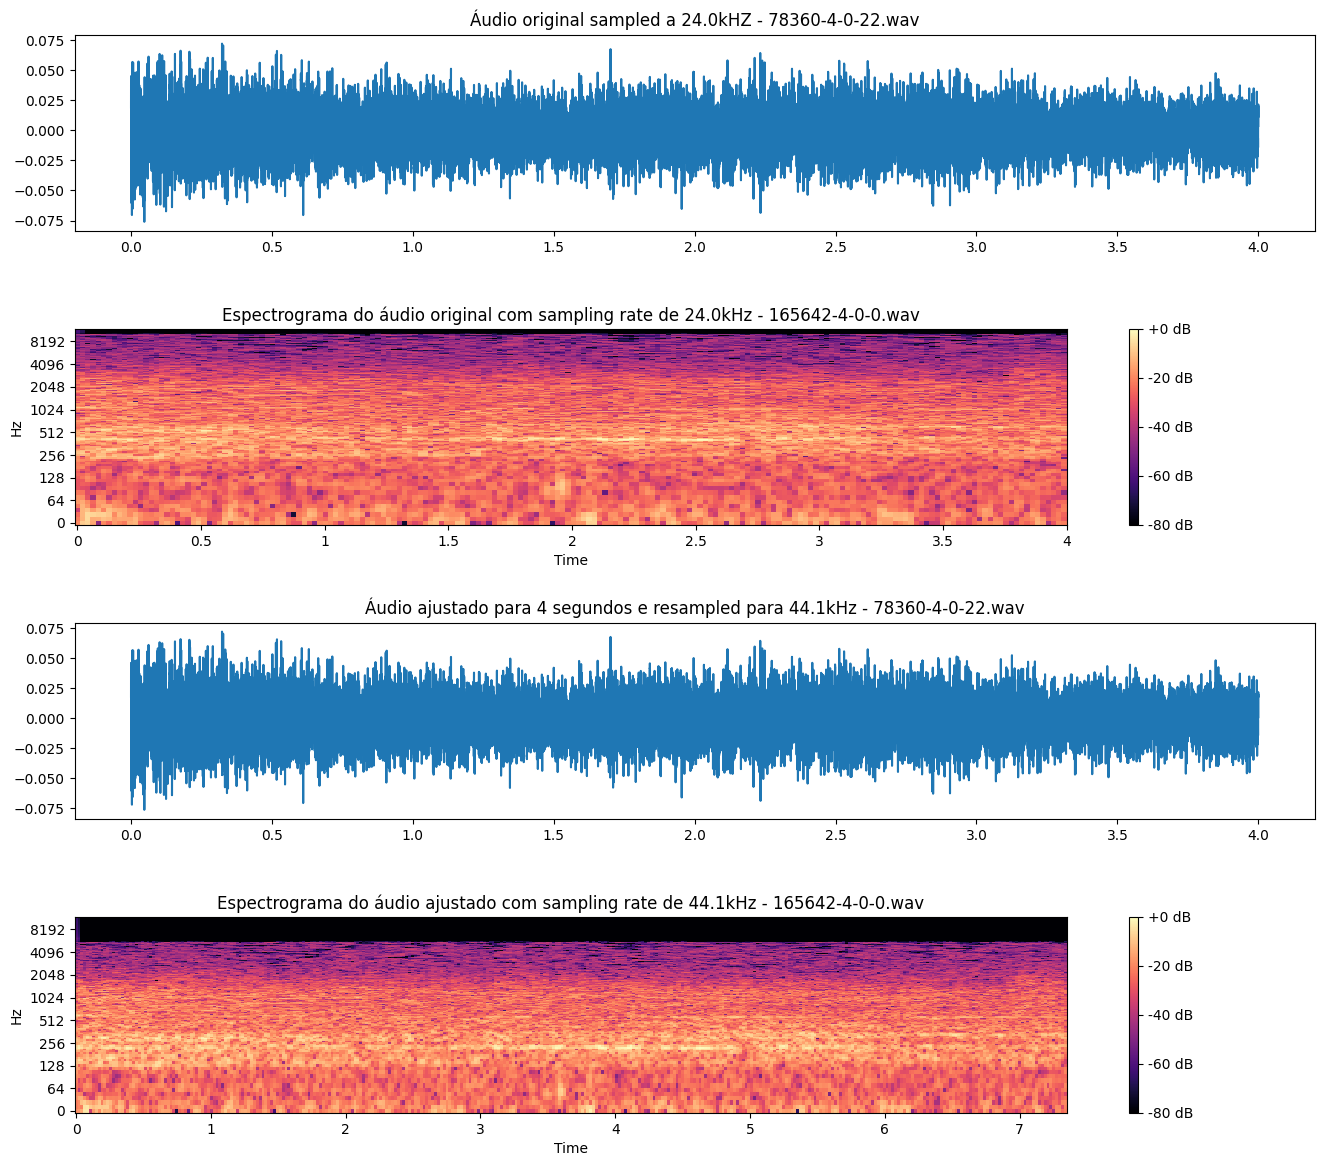

In [125]:
fold1_path = os.path.join(AUDIO_PATH, "fold1")
filenames = os.listdir(fold1_path)
index = 769

path = os.path.join(fold1_path,filenames[index])

audio_data_ori, sr = librosa.load(path,sr=None)
audio_data_adj = reformat_audio_data(path)
plt.figure(figsize=(16,14))
plt.subplot(4,1,1)
plt.plot(np.linspace(0, len(audio_data_ori) / sr, num=len(audio_data_ori)), audio_data_ori)
plt.title(f'Áudio original sampled a {sr/1000}kHZ - {filenames[index]}')

spectrogram = np.abs(librosa.stft(audio_data_ori))
plt.subplot(4,1,2)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title(f'Espectrograma do áudio original com sampling rate de {sr/1000}kHz - {filenames[1]}')
plt.colorbar(format='%+2.0f dB')

plt.subplot(4,1,3)
plt.plot(np.linspace(0, len(audio_data_adj) / SAMPLE_RATE, num=len(audio_data_adj)), audio_data_adj)
plt.title(f'Áudio ajustado para 4 segundos e resampled para {SAMPLE_RATE/1000}kHz - {filenames[index]}')

spectrogram = np.abs(librosa.stft(audio_data_adj))
plt.subplot(4,1,4)
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sr)
plt.title(f'Espectrograma do áudio ajustado com sampling rate de {SAMPLE_RATE/1000}kHz - {filenames[1]}')
plt.colorbar(format='%+2.0f dB')

plt.subplots_adjust(hspace=0.5)

In [127]:
def create_MLP(x_train_shape):
    modelMLP = Sequential()
    modelMLP.add(Dense(256, activation='relu', input_shape=x_train_shape))
    modelMLP.add(Dropout(0.1))
    modelMLP.add(Dense(256, activation='relu'))
    modelMLP.add(Dropout(0.1))
    modelMLP.add(Dense(10, activation='softmax'))

    modelMLP.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

    modelMLP.summary()
    return modelMLP